Ершов Артём

## Benchmark BayesHammer (SPAdes) and Tadpole* (BBTools)

\* BBDuk, насколько я понял, только фильтрует риды, а не исправляет ошибки. Для исправления ошибок в мануале рекомендуют использовать Tadpole (или BBNorm, если Tadpole упадёт по памяти...) - [source](https://jgi.doe.gov/data-and-tools/bbtools/bb-tools-user-guide/data-preprocessing)


Alignment & filtering commands:
```bash
# BayesHammer (SPAdes)
spades.py --only-error-correction -1 ecoli_10K_err_1.fastq -2 ecoli_10K_err_2.fastq -o test
# tadpole (BBTools)
tadpole.sh in=ecoli_10K_err_1.fastq in2=ecoli_10K_err_2.fastq \ 
    out=10K_tadpole_R1.fastq.gz out2=10K_tadpole_R2.fastq.gz mode=correct


# alignment 
bwa mem MG1655-K12.first10K.fasta ecoli_10K_err_1.fastq ecoli_10K_err_2.fastq -t 8 | samtools sort -O sam -n > test_raw.sam

bwa mem -t 8 MG1655-K12.first10K.fasta 10K_spades_R1.fastq.gz 10K_spades_R2.fastq.gz | samtools sort -n -O sam > test_spades.sam

bwa mem -t 8 MG1655-K12.first10K.fasta 10K_tadpole_R1.fastq.gz 10K_tadpole_R2.fastq.gz | samtools sort -n -O sam > test_bbtools.sam
```
Идея решения: 
1. Для каждого сырого рида найти его обработанного собрата.
2. Достать последовательность референса, на которую выравнились обе версии рида.
3. Выполнить для трёх последовательностей (участок референса и два рида) множественное выравнивание (MUSCLE).
4. Пройтись по выравниванию и посчитать статистики.

Маскировку (замену нуклеотидов на N) учитывать не будем.

In [12]:
import os
import subprocess
import uuid
import pickle

from Bio import SeqIO
import pysam
import pandas as pd
from IPython.display import display

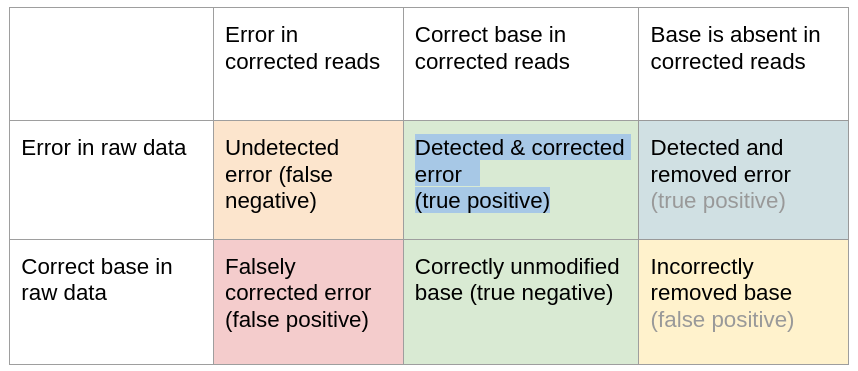

In [5]:
def ecstats(raw_sam_file, cor_sam_file, cwd='./'): 
    general_stats = {'TN': 0, 'FN': 0, 'TP': 0, 'FP': 0, 'TN': 0, 'TPrem': 0, 'FPrem': 0}
    
    iterations = 0
    skipped_aln = 0
    skipped_name = 0
    skipped_md = 0
   
    tmp_uuid = str(uuid.uuid4())   # generate names for temp files
    tmp_reads = cwd + tmp_uuid + '.fasta'    # fasta for ref.seq., raw and corrected reads
    tmp_msa = cwd + tmp_uuid + '_align.fasta'  # for their alignment
    
    with pysam.AlignmentFile(cwd + raw_sam_file, 'r') as raw, \
        pysam.AlignmentFile(cwd + cor_sam_file, 'r') as cor:
            cor_iter = cor.fetch()   # because of the sorting, relative oreder
            raw_iter = raw.fetch()   # of the reads is the same in both files
            while True:
                try:
                    cor_read = next(cor_iter)  # if the read names do no match, it 
                    raw_read = next(raw_iter)  # means that the raw read was filtered out
                    while raw_read.query_name != cor_read.query_name:
                        skipped_name += 1
                        raw_read = next(raw_iter)
                        
                    # check that raw and corrected read align roughly to the same spot
                    # skip, if they do not or the reads do no align
                    cor_start = cor_read.reference_start
                    raw_start = raw_read.reference_start
                    if abs(cor_start - raw_start) > 50 or cor_start < 0 or raw_start < 0:
                        skipped_aln += 1
                        continue
                       
                    cor_ref = cor_read.get_reference_sequence().upper()
                    raw_ref = raw_read.get_reference_sequence().upper()
                    
                    # find the 'arch reference' which covers both reference seqs
                    mutual_ref = ''
                    if cor_start < raw_start:
                        mutual_ref += cor_ref[:raw_start - cor_start]
                        mutual_ref += raw_ref
                        mutual_ref += cor_ref[len(mutual_ref):]
                    elif cor_start > raw_start:
                        mutual_ref += raw_ref[:cor_start - raw_start]
                        mutual_ref += cor_ref
                        mutual_ref += raw_ref[len(mutual_ref):]
                    else:
                        mutual_ref = cor_ref if len(cor_ref) > len(raw_ref) else raw_ref

                    # perform multiple sequence alignment via MUSCLE
                    with open(tmp_reads, 'w') as fasta:
                        fasta.write('>REF\n' + mutual_ref + '\n')
                        fasta.write('>RAW\n' + raw_read.seq + '\n')
                        fasta.write('>COR\n' + cor_read.seq)
                    subprocess.run(['muscle', '-quiet', '-in', tmp_reads, 
                                    '-out', tmp_msa])
                    seqs = {seq.name: seq.seq for seq in SeqIO.parse(tmp_msa, 'fasta')}
                    
                    # check bases 
                    stats = {k: 0 for k in general_stats.keys()}
                    for true_base, raw_base, cor_base in zip(seqs['REF'], seqs['RAW'], 
                                                             seqs['COR']):
                        if cor_base == 'N':
                            continue  # ignore masking 
                        if true_base == raw_base == cor_base:
                            stats['TN'] += 1

                        elif true_base == raw_base != cor_base:  
                            if all(base != '-' for base in (true_base, raw_base, cor_base)):
                                stats['FP'] += 1
                                
                            elif cor_base == '-':
                                stats['FPrem'] += 1

                        elif true_base == cor_base != raw_base:
                            if true_base == '-':
                                stats['TPrem'] += 1
                            else:
                                stats['TP'] += 1

                        elif true_base != cor_base == raw_base:
                            stats['FN'] += 1
                    
                    # check trimming
                    i = 0  # from start
                    while seqs['COR'][i] == '-':
                        if seqs['REF'][i] == '-':  # correct trimming
                            stats['TPrem'] += 1
                        elif seqs['REF'][i] == seqs['RAW'][i]:
                            stats['FPrem'] += 1
                        i += 1
                    i = len(seqs['REF']) - 1  # from end
                    while seqs['COR'][i] == '-':
                        if seqs['REF'][i] == '-':
                            stats['TPrem'] += 1
                        elif seqs['REF'][i] == seqs['RAW'][i]:
                            stats['FPrem'] += 1
                        i -= 1       

                    # aggregate the results
                    for k in general_stats.keys():
                        general_stats[k] += stats[k]
                    
                    iterations += 1
                    
                except ValueError:  # no MD tag present -> skip'
                    skipped_md += 1
                    continue
        
                except StopIteration: 
                    os.remove(tmp_reads)
                    os.remove(tmp_msa)
                    break 
    return general_stats


In [3]:
def error_matrix(stats):
    df = pd.DataFrame(np.array([
        ['Error in raw data', stats['FN'], stats['TP'], stats['TPrem']],
        ['Correct base in raw data', stats['FP'], stats['TN'], stats['FPrem']]
    ]))
    df.columns = ['',
                  'Error in corrected reads', 
                  'Correct base in corrected reads',
                  'Base is absent in corrected reads']
    df.set_index('', inplace=True)
    return df

In [94]:
folder = 'HW4_data/'
raw_sam = 'test_raw.sam'
spades_sam = 'test_spades.sam'
bbtools_sam = 'test_bbtools.sam'

bbtools_stats = ecstats(raw_sam, bbtools_sam, folder)
spades_stats = ecstats(raw_sam, spades_sam, folder)

print('BayesHammer:')
display(error_matrix(spades_stats))

print('Tadpole:')
display(error_matrix(bbtools_stats))

BayesHammer:


,Error in corrected reads,Correct base in corrected reads,Base is absent in corrected reads
,,,
Error in raw data,6456,19458,4
Correct base in raw data,14,5214113,0


Tadpole:


,Error in corrected reads,Correct base in corrected reads,Base is absent in corrected reads
,,,
Error in raw data,135433,68482,41
Correct base in raw data,1,5717578,30


In [102]:
fn = 6456
tp = 19458
print('BayesHammer Recall:', tp / (tp + fn))
fn = 135433
tp = 68482
print('Tadpole Recall:', tp / (tp + fn))

BayesHammer Recall: 0.750868256540866
Tadpole Recall: 0.3358360101022485


При дефолтных параметрах у Tadpole на толику выше Precision, но существенно ниже Recall. 

Впрочем, такое сравнение не совсем честное, потому что в отличие от BayesHammer, сам Tadpole не маскирует основания, в которых не уверен (для этого в BBTools есть другие инструменты).

P.S. Скрипт работает достаточно долго, результаты с основными данными добавлю позже...

---
---

In [13]:
folder = 'HW4_data/'
raw_sam = 'full_raw.sam'
spades_sam = 'full_spades.sam'
bbtools_sam = 'full_tadpole.sam'

bbtools_stats = ecstats(raw_sam, bbtools_sam, folder)
with open(folder + 'bbtools_results.pickle', 'wb') as f:
    pickle.dump(bbtools_stats, f)
spades_stats = ecstats(raw_sam, spades_sam, folder)
with open(folder + 'spades_results.pickle', 'wb') as f:
    pickle.dump(spades_stats, f)

In [14]:
print('BayesHammer:')
display(error_matrix(spades_stats))
print('Tadpole:')
display(error_matrix(bbtools_stats))


BayesHammer:


,Error in corrected reads,Correct base in corrected reads,Base is absent in corrected reads
,,,
Error in raw data,378729,856900,44
Correct base in raw data,587,246618325,18


Tadpole:


,Error in corrected reads,Correct base in corrected reads,Base is absent in corrected reads
,,,
Error in raw data,4043757,2879087,2001
Correct base in raw data,359,267137807,802


В целом тренд схожий.